# MidiNet用データの作成，前処理

用意するデータ
- bar (N, steps, pitch_range)
- bar_prev (N, steps, pitch_range)
- chord (N, 13) (0~12は主音，13は0: major, 1: minor)

処理の方針  
次の4つのタイプのデータを用意
- original: 論文に書かれているもの
- original_full: originalではノンダイアトニックコードを含む曲を排除するが，こちらは小節単位で排除する
- natural: これまでに作られているプロセッサを使って自然だと思うものを作る
- headed: 音符の開始地点に，何ステップ伸びる音符であるかを記したもの(損失関数を変える必要はないか?)
  
次のようなデータも扱いたいが，これらはモデルの改変が必要である
- section: verse,chorusなど，小節のセクション情報を6次元ベクトルにしてコードベクトルに結合したもの
- clipped: MIDI音程を36～99の64ピッチ以内にシフトし，64入力のモデルで学習
- diatonic: コードをルート音7つのみで表現したもの
- head-conditioned: 音符の開始地点であるという情報を別のチャネルにしたもの

## データ読込

In [1]:
import os, ipdb, pickle
import numpy as np
import pandas as pd
from pypianoroll import Multitrack, Track
from processors import PypianorollProcessor, Processor
from utils import grid_plot, Timer
from multiprocessing import Pool, cpu_count

print(f"{cpu_count()} cpus are available.")

import matplotlib.pyplot as plt
%matplotlib inline

20 cpus are available.


In [3]:
base_dir = "../datasets/theorytab"
input_dir = f"{base_dir}/pianoroll"
input_csv = f"{base_dir}/theorytab.csv"
output_dir = f"{base_dir}/midinet"

In [3]:
df_org = pd.read_csv(input_csv)
print(df_org.shape)
df_org.head()

(39614, 21)


,Unnamed: 0,path,artist,song,part,nokey,key_signature,estimated_key_signature,in_scale_rate,estimated_in_scale_rate,...,lowest_melody,highest_chord,lowest_chord,bpm,time_signature,beats,bars,time,has_melody_track,has_chord_track
0,0,q/quincy-jones-and-his-orchestra/soul-bossa-no...,quincy-jones-and-his-orchestra,soul-bossa-nova,chorus,False,Bb Major,Bb Major,0.88278,0.88278,...,65.0,63.0,43.0,146,4/4,48,12,19.73,True,True
1,1,q/quincy-jones-and-his-orchestra/soul-bossa-no...,quincy-jones-and-his-orchestra,soul-bossa-nova,chorus,True,Bb Major,C Major,0.74186,0.88278,...,55.0,60.0,43.0,146,4/4,48,12,19.73,True,True
2,2,q/queen-and-bowie/under-pressure/intro-and-ver...,queen-and-bowie,under-pressure,"intro,verse",False,D Major,D Major,1.00000,1.00000,...,57.0,57.0,45.0,120,4/4,32,8,16.00,True,True
3,3,q/queen-and-bowie/under-pressure/intro-and-ver...,queen-and-bowie,under-pressure,"intro,verse",True,D Major,C Major,0.74297,1.00000,...,55.0,55.0,43.0,120,4/4,32,8,16.00,True,True
4,4,q/queen-and-bowie/under-pressure/intro_nokey.mid,queen-and-bowie,under-pressure,intro,True,D Major,C Major,0.65812,1.00000,...,55.0,59.0,48.0,240,4/4,32,8,8.00,True,True


In [4]:
df = df_org
df = df[df["nokey"] & (df["time_signature"] == "4/4")]
df = df[df["has_melody_track"] & df["has_chord_track"]]
df = df.reset_index()
print(df.shape)
df.head()

(16386, 22)


,index,Unnamed: 0,path,artist,song,part,nokey,key_signature,estimated_key_signature,in_scale_rate,...,lowest_melody,highest_chord,lowest_chord,bpm,time_signature,beats,bars,time,has_melody_track,has_chord_track
0,1,1,q/quincy-jones-and-his-orchestra/soul-bossa-no...,quincy-jones-and-his-orchestra,soul-bossa-nova,chorus,True,Bb Major,C Major,0.74186,...,55.0,60.0,43.0,146,4/4,48,12,19.73,True,True
1,3,3,q/queen-and-bowie/under-pressure/intro-and-ver...,queen-and-bowie,under-pressure,"intro,verse",True,D Major,C Major,0.74297,...,55.0,55.0,43.0,120,4/4,32,8,16.00,True,True
2,4,4,q/queen-and-bowie/under-pressure/intro_nokey.mid,queen-and-bowie,under-pressure,intro,True,D Major,C Major,0.65812,...,55.0,59.0,48.0,240,4/4,32,8,8.00,True,True
3,9,9,q/queen/the-show-must-go-on/intro-and-verse_no...,queen,the-show-must-go-on,"intro,verse",True,B Major,C minor,0.38155,...,59.0,60.0,43.0,83,4/4,57,14,40.48,True,True
4,11,11,q/queen/the-show-must-go-on/bridge_nokey.mid,queen,the-show-must-go-on,bridge,True,C Major,A minor,1.00000,...,57.0,60.0,43.0,84,4/4,24,6,17.14,True,True


nokeyのものが信用できない  
estimated_key_signatureがC Majorのものを選んだ方が良いのではないだろうか  
そうすると8000くらいにめちゃくちゃ減るけど  
Key=CにはしたけどMajorとは言ってないみたいなのが含まれている？

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid


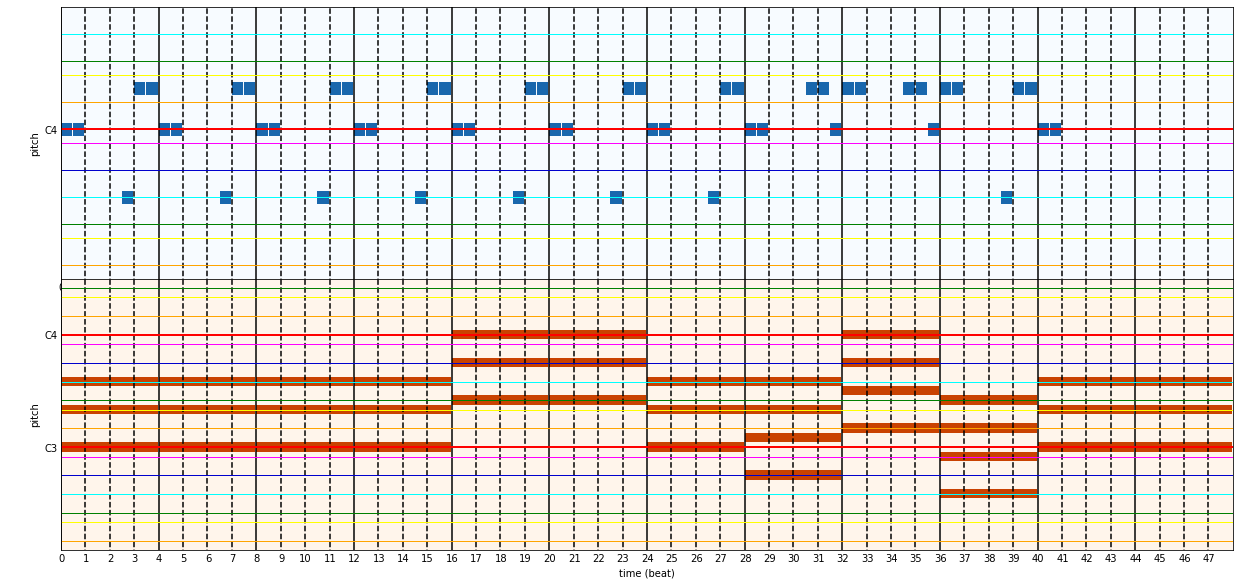

In [5]:
def get_sample(index=0, get_series=False):
    path = df['path'][index]
    ppr = Multitrack(os.path.join(input_dir, path))
    print(f"sample {index} picked from {path}")
    if get_series:
        return ppr, df[index:index+1]
    else:
        return ppr

grid_plot(get_sample())

## 処理フレームワーク
Processorを継承したクラスのインスタンスをPreprocessorへ与えてやることで前処理を行う  
Processorはリストで`PypianorollProcessor.__call__`へ渡され，pypianoroll.Multitrackとdataを順番に受け取っては処理していく  
最終的に得られたprocessed_melody(x, prev_x)とchordをzipしてpickleで保存  
それを取り出してDatasetとして扱い，DataLoaderへ渡す腹積もり

In [6]:
class TestProcessor(Processor):
    def __init__(self, number):
        self.number = number

    def __call__(self, ppr, data):
        print(f"test process {self.number}")
        return ppr, data

with Timer():
    ppr = get_sample()

with Timer():
    processors = [TestProcessor(i) for i in range(3)]
    melody = ppr.tracks[0]
    ppr, melody = PypianorollProcessor(processors)(ppr, melody)

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
0.006405
test process 0
test process 1
test process 2
0.000065


MIDIデータの読み込みに1/100secくらいかかるんだなぁ  
読込みだけで4分くらいかかるんだなぁ  
並列処理すればその限りではないけどなぁ

## 共通の前処理
- ベロシティは無視し，2値化する
- 最小ステップを16分音符にする
    - メロディのdown_resolutionするときの最初のステップにある音をそのステップの音とする
    - i.e. resolution: 24 -> 4なら，24 / 4 = 6ステップごとにある音をそのステップの音とする
    - 3連符や32分音符を取り除く
        - down_resolutionの過程で消える．(removeしていることにはなる．)
        - 3連符はつながっていればドレミ→ドドレミとなる
- メロディに音符のない小節は使用しない
- コードは，最初の12個を主音，最後をメジャーかマイナーの区別に使う．
    - 小節の最初のステップの和音を使い，1小節に1つのコードを割り当てる．
        - 分数コードや転回はないと踏む
        - コードトラックの小節の先頭で一番低い音をルートとする．
        - メジャーかマイナーかは次に低い音との距離で決定する．
- x:(bars, 16, 128), prev_x: (bars, 16, 128), chord: (bars, 13)のデータを得る
- 12個分のキーシフトを行うことでデータの水増しを行う
    - 上に11シフト

### ベロシティは無視し，2値化する

In [7]:
class Binarize(Processor):
    def __call__(self, ppr, track):
        ppr.binarize()
        track.binarize()
        return ppr, track

In [8]:
ppr = get_sample()
binarize = Binarize()

with Timer():
    ppr, track = binarize(ppr, ppr.tracks[0])
print(ppr.is_binarized(), track.is_binarized())

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
0.000553
True True


### resolutionを下げる

In [9]:
class DownBeatResolution(Processor):
    """
    全てのトラックのresolutionを下げるので注意
    """
    def __init__(self, resolution_to, resolution_from=None, beats_in_bar=4):
        self.res_to = resolution_to
        self.res_from = resolution_from
        self.beats_in_bar = beats_in_bar
        
        if self.res_from is not None and self.res_to >= self.res_from:
            raise ValueError(f"Resolution_to (given: {self.res_to}) must be smaller than resolution_from (given: {self.res_from}).")
        
    def __call__(self, ppr, track):
        if self.res_from is None:
            if self.res_to >= ppr.beat_resolution:
                raise ValueError(f"Target resolution ({self.res_to}) must be smaller than the original resolution ({ppr.beat_resolution})")
            step_width = ppr.beat_resolution // self.res_to
        else:
            step_width = self.res_from // self.res_to
        
        bar_res = self.beats_in_bar * ppr.beat_resolution
        song_len = len(ppr.downbeat) // bar_res * bar_res
        
        ppr.beat_resolution = self.res_to
        ppr.downbeat = ppr.downbeat[:song_len:step_width]
        
        track_is_in_ppr = False
        for ppr_track in ppr.tracks:
            if ppr_track is track: track_is_in_ppr = True # isは参照の等価チェック
            ppr_track.pianoroll = ppr_track.pianoroll[:song_len:step_width]
        
        if not track_is_in_ppr:
            track.pianoroll = track.pianoroll[:song_len:step_width]
        
        return ppr, track

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
before -> resolution: 24, active length: 1151
0.000013
after: -> resolution: 4, active length: 192


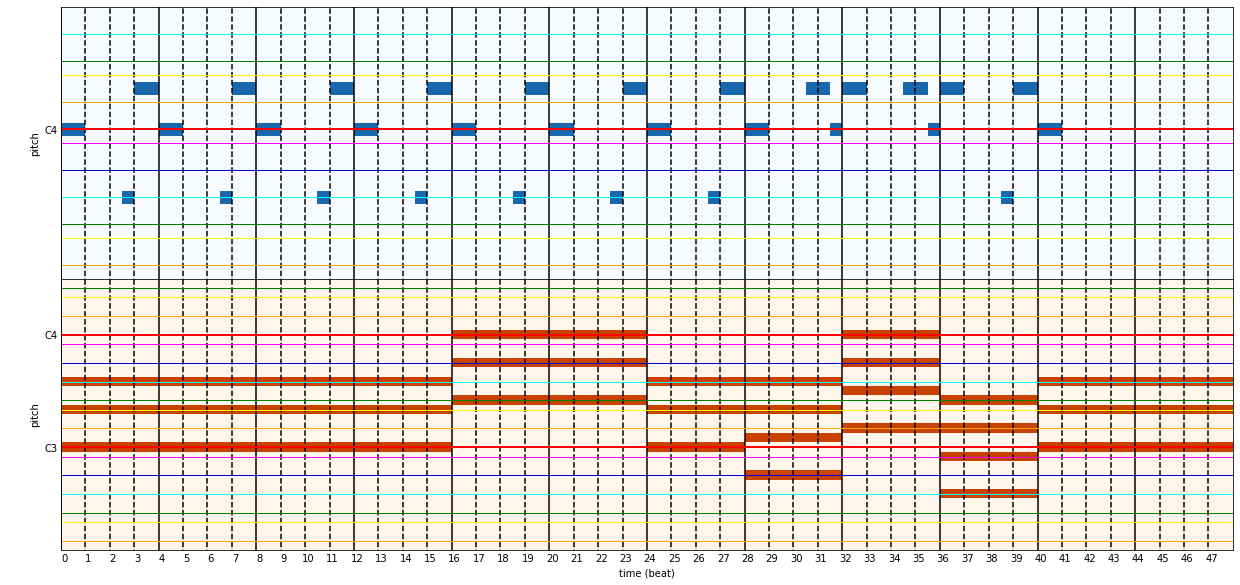

In [10]:
ppr = get_sample()
down_resolution = DownBeatResolution(4)

print(f"before -> resolution: {ppr.beat_resolution}, active length: {ppr.get_active_length()}")
with Timer():
    ppr, track = down_resolution(ppr, ppr.tracks[0])
print(f"after: -> resolution: {ppr.beat_resolution}, active length: {ppr.get_active_length()}")
grid_plot(ppr)

### メロディに音符のない小節は使用しない

In [11]:
class RemoveEmptyBars(Processor):
    def __init__(self, beats_in_bar=4):
        self.beats_in_bar = beats_in_bar
    
    def __call__(self, ppr, track):
        song_len = len(ppr.downbeat)
        if song_len == 0:
            return ppr, track
        
        res = ppr.beat_resolution
        bar_res = self.beats_in_bar * res
        bars = int(np.ceil(song_len / bar_res))
        
        empty_steps = []
        for b in range(bars):
            left, right = b*bar_res, min((b+1)*bar_res, song_len)
            if not track.pianoroll[left:right].any():
                empty_steps += list(range(left, right))
        
        ppr.downbeat = np.delete(ppr.downbeat, empty_steps)
        
        track_is_in_ppr = False
        for ppr_track in ppr.tracks:
            if ppr_track is track: track_is_in_ppr = True
            ppr_track.pianoroll = np.delete(ppr_track.pianoroll, empty_steps, axis=0)

        if not track_is_in_ppr:
            track.pianoroll = np.delete(track.pianoroll, empty_steps, axis=0)
                    
        return ppr, track

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
before -> active length: 1151
0.000570
after: -> active length: 1055


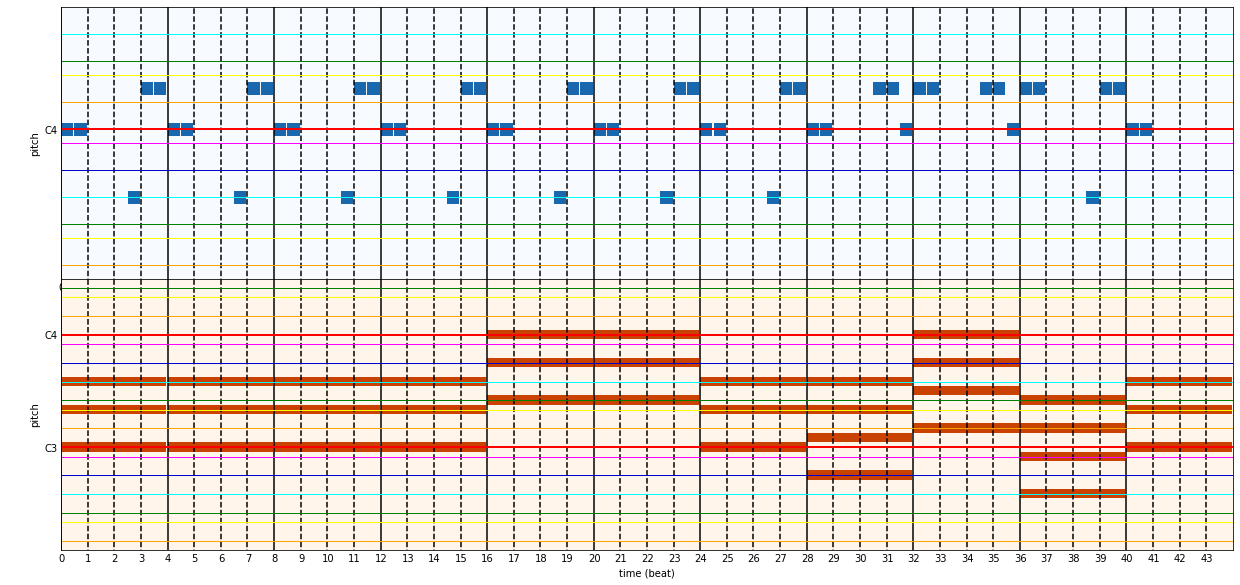

In [12]:
ppr = get_sample()
remove_empty_bars = RemoveEmptyBars()

print(f"before -> active length: {ppr.get_active_length()}")
with Timer():
    ppr, track = remove_empty_bars(ppr, ppr.tracks[0])
print(f"after: -> active length: {ppr.get_active_length()}")
grid_plot(ppr)

### コードベクトルの取得

In [13]:
class GetChordVectors(Processor):
    def __init__(self, minor=0, major=1, beats_in_bar=4):
        self.beats_in_bar = beats_in_bar
    
    def __call__(self, ppr, track):
        beat_res = ppr.beat_resolution
        bar_res = beat_res * self.beats_in_bar
        pianoroll = track.pianoroll
        
        chord_vecs = []
        for head in range(0, pianoroll.shape[0], bar_res):
            chord = np.where(pianoroll[head])[0]
            
            chord_vec = np.zeros(13)
            if len(chord) > 1:
                chord_vec[chord[0] % 12] = 1
                chord_vec[-1] = 0 if chord[1] - chord[0] == 3 else 1
            
            chord_vecs.append(chord_vec)
        
        return ppr, np.array(chord_vecs)

In [14]:
ppr = get_sample()
get_chord_vectors = GetChordVectors()

with Timer():
    ppr, chord_vecs = get_chord_vectors(ppr, ppr.tracks[1])
print(chord_vecs.shape)
for cv in chord_vecs:
    print(cv)

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
0.000482
(12, 13)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


### メロディを小節ごとに分割

In [15]:
class GetBars(Processor):
    def __init__(self, beats_in_bar=4):
        self.beats_in_bar = beats_in_bar
    
    def __call__(self, ppr, track):
        nproll = track.pianoroll if isinstance(track, Track) else track        
        beat_res = ppr.beat_resolution
        bar_res = beat_res * self.beats_in_bar
        song_len = len(ppr.downbeat)
        bar_num = int(np.ceil(song_len / bar_res))
        
        bars = np.zeros([bar_num, bar_res, nproll.shape[-1]])
        for bar in range(bar_num):
            left, right = bar*bar_res, min((bar+1)*bar_res, song_len)
            bars[bar, :(right-left)] = nproll[left:right]
        
        return ppr, bars

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
bar resolution: 96
0.000994
(12, 96, 128)


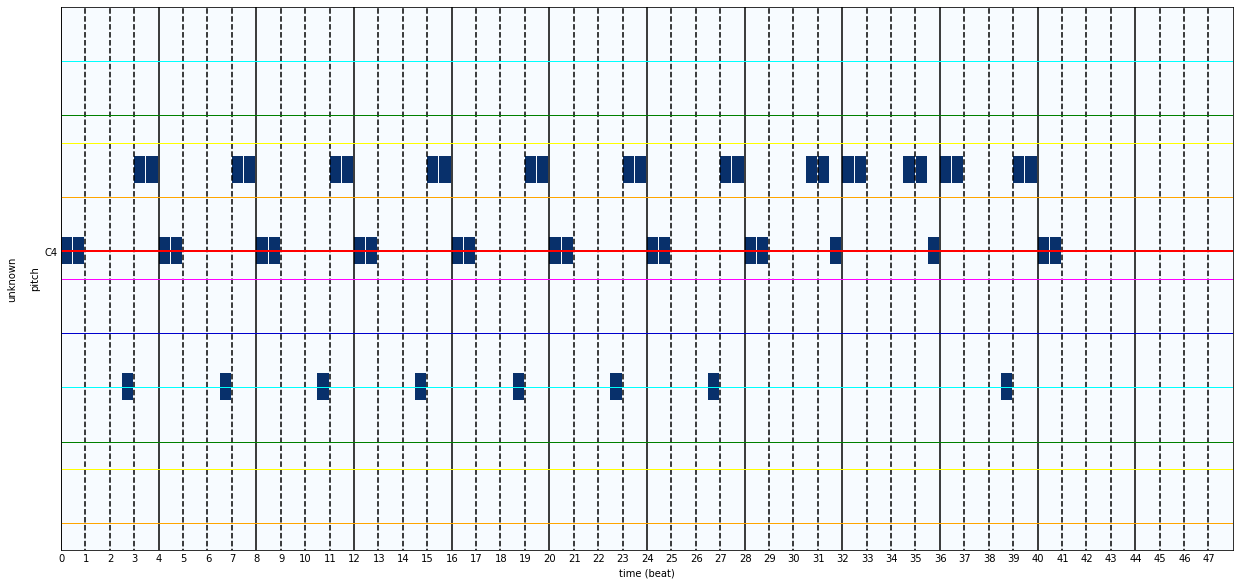

In [16]:
ppr = get_sample()
get_bars = GetBars()

print("bar resolution:", ppr.beat_resolution * 4)
with Timer():
    ppr, bars = get_bars(ppr, ppr.tracks[0])
print(bars.shape)
grid_plot(Track(pianoroll=np.vstack(bars)), beat_resolution=ppr.beat_resolution)

### キーシフトによるデータの水増し
- bars (bars, 16, 128) -> np.array(bars * 12, 16, 128)
- Track.pianoroll (length, 128) -> np.array(length * 12, 128)

配列からはどこからどこまでが1曲分なのかが分からないかもしれないが，1曲分の長さはpprから取得してもらうことにする．  
そうでなくても長さを12等分すればいい  
データ数を爆発させないようにするのと変な音程を学習しないよう，メジャーキーなど，シフト数のリストも渡せるようにした

In [17]:
class AugumentBars(Processor):
    def __init__(self, shifts=12, up=True):
        self.keys = shifts if isinstance(shifts, list) else range(shifts)
        self.up = up
    
    def get_active_range(self, bars):
        lowest, highest = 0, 127
        while not np.any(bars[:, :, lowest]) and lowest < 127: lowest += 1
        while not np.any(bars[:, :, highest]) and highest > 0: highest -= 1
        if lowest > highest: return None, None
        return lowest, highest
    
    def __call__(self, ppr, bars):
        if bars.ndim != 3:
            return ppr, bars
        s0, s1, s2 = bars.shape
        augumented_bars = np.zeros([s0 * len(self.keys), s1, s2])
        lowest, highest = self.get_active_range(bars)
        if lowest and highest:
            clipped_bars = bars[:, :, lowest:highest+1]
            for i, s in enumerate(self.keys):
                if self.up:
                    bottom, top = np.clip(lowest+s, 0, 127), np.clip(highest+s, 0, 127) + 1
                else:
                    bottom, top = np.clip(lowest-s, 0, 127), np.clip(highest-s, 0, 127) + 1
                augumented_bars[s0*i:s0*(i+1), :, bottom:top] = clipped_bars[:, :, 0:top-bottom]
        return ppr, augumented_bars

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
input shape: (12, 96, 128)
0.004836
(84, 96, 128)


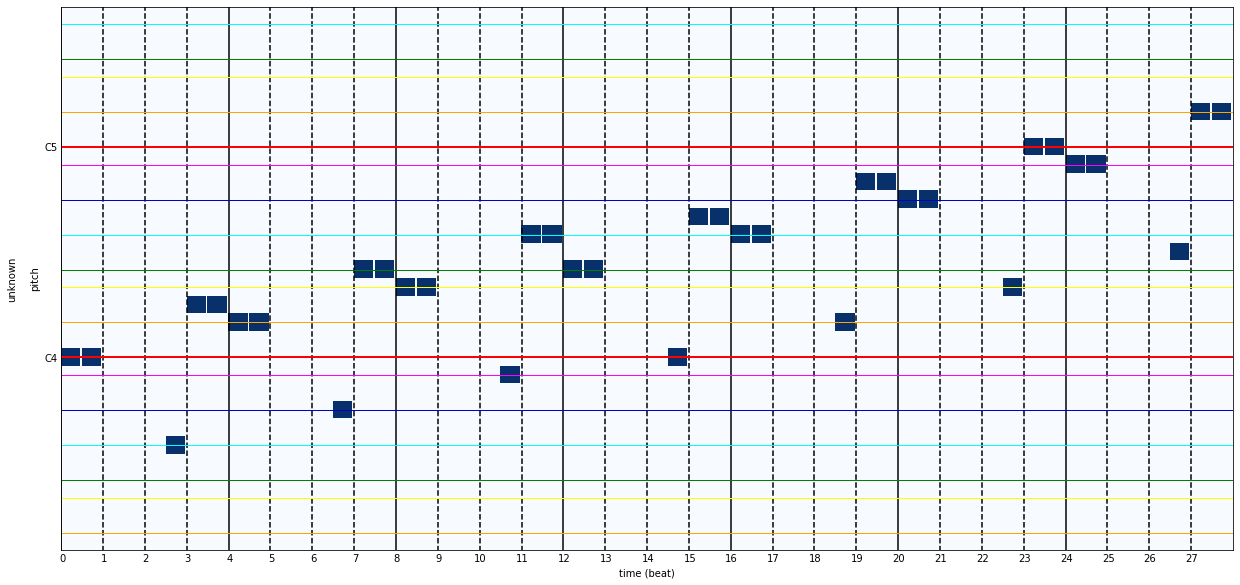

In [18]:
ppr = get_sample()
# augument_bars = AugumentBars()
augument_bars = AugumentBars(shifts=[0, 2, 4, 5, 7, 9, 11])

ppr, bars = get_bars(ppr, ppr.tracks[0])
bars_num = bars.shape[0]
print("input shape:", bars.shape)
with Timer():
    ppr, bars = augument_bars(ppr, bars)
print(bars.shape)
grid_plot(Track(pianoroll=np.vstack(bars[0::bars_num])), beat_resolution=ppr.beat_resolution)

In [19]:
class AugumentTrack(Processor):
    def __init__(self, shifts=12, up=True):
        self.keys = shifts if isinstance(shifts, list) else range(shifts)
        self.up = up
    
    def get_active_range(self, nproll):
        pitches = np.where(nproll)[1]
        return np.min(pitches), np.max(pitches)
    
    def __call__(self, ppr, track):
        bars = track.pianoroll if isinstance(track, Track) else track
        if bars.ndim != 2:
            return ppr, bars
        s0, s1 = bars.shape
        augumented_bars = np.zeros([s0 * len(self.keys), s1])
        lowest, highest = self.get_active_range(bars)
        if lowest and highest:
            clipped_bars = bars[:, lowest:highest+1]
            for i, s in enumerate(self.keys):
                if self.up:
                    bottom, top = np.clip(lowest+s, 0, 127), np.clip(highest+s, 0, 127) + 1
                else:
                    bottom, top = np.clip(lowest-s, 0, 127), np.clip(highest-s, 0, 127) + 1
                augumented_bars[s0*i:s0*(i+1), bottom:top] = clipped_bars[:, 0:top-bottom]        
        return ppr, augumented_bars

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
input shape: (1152, 128)
0.005402
(8064, 128)


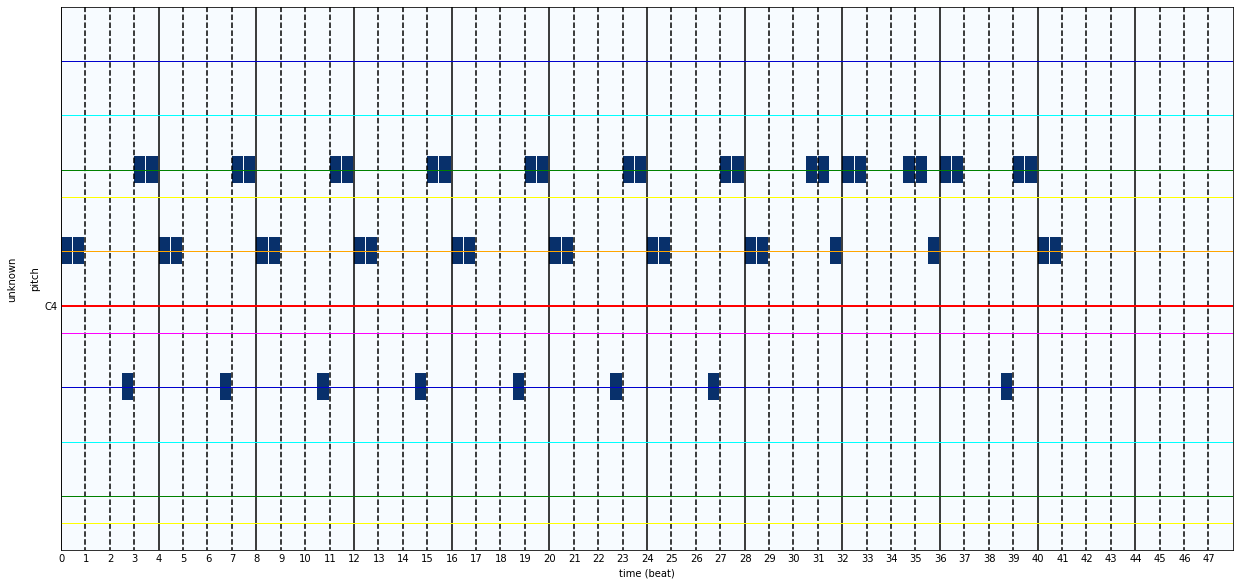

In [20]:
ppr = get_sample()
# augument_track = AugumentTrack()
augument_track = AugumentTrack(shifts=[0, 2, 4, 5, 7, 9, 11])

print("input shape:", ppr.tracks[0].pianoroll.shape)
with Timer():
    ppr, bars = augument_track(ppr, ppr.tracks[0])
print(bars.shape)
i = 1
length = len(ppr.downbeat)
grid_plot(Track(pianoroll=np.vstack(bars[length*i:length*(i+1)])), beat_resolution=ppr.beat_resolution)

In [21]:
class AugumentChordVectors(Processor):
    def __init__(self, shifts=12, up=True):
        self.keys = shifts if isinstance(shifts, list) else range(shifts)
        self.up = up
    
    def __call__(self, ppr, chord_vecs):
        if chord_vecs.ndim != 2:
            return ppr, chord_vecs
        chord_num, vec_length = chord_vecs.shape
        augumented_cv = np.zeros([chord_num * len(self.keys), vec_length])
        augumented_cv[:chord_num, :] = chord_vecs
        
        for k in range(len(self.keys)):
            augumented_cv[k*chord_num:(k+1)*chord_num, -1:] = chord_vecs[:, -1:]
        
        for bar, chord_vec in enumerate(chord_vecs):
            for chord, is_set in enumerate(chord_vec):
                if is_set:
                    for i, shift in enumerate(self.keys):
                        step_to_be_set = i * chord_num + bar
                        chord_to_be_set = (chord + (shift if self.up else - shift)) % 12
                        augumented_cv[step_to_be_set, chord_to_be_set] = 1
                    break
        
        return ppr, augumented_cv

In [22]:
ppr = get_sample()
# augument_cv = AugumentChordVectors()
augument_cv = AugumentChordVectors(shifts=[0, 2, 4, 5, 7, 9, 11])

with Timer():
    ppr, chord_vecs = get_chord_vectors(ppr, ppr.tracks[1])
    chord_vecs[3, -1] = 0
    ppr, augumented_cv = augument_cv(ppr, chord_vecs)

print("input shape:", chord_vecs.shape)
print("output shape:", augumented_cv.shape)
cv_len = len(chord_vecs)
i = 1
print()
print(augumented_cv[i*12:(i+1)*12])
print()
for i in range(int(augumented_cv.shape[0] / chord_vecs.shape[0])):
    chords_in_key = augumented_cv[i*cv_len:(i+1)*cv_len, :-1]
    print(np.where(chords_in_key)[1])

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
0.000235
input shape: (12, 13)
output shape: (84, 13)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[0 0 0 0 5 5 0 9 2 7 0 0]
[ 2  2  2  2  7  7  2 11  4  9  2  2]
[ 4  4  4  4  9  9  4  1  6 11  4  4]
[ 5  5  5  5 10 10  5  2  7  0  5  5]
[7 7 7 7 0 0 7 4 9 2 7 7]
[ 9  9  9  9  2  2  9  6 11  4  9  9]
[11 11 11 11  4  4 11  8  1  6 11 11]


### 前小節データを得る
水増ししたものに対応する．  
「シフト→前小節」のほうが「前小節→シフト」よりもコストが少ない．  
前小節を取得するのは配列範囲の選択でいいが，二倍になった小節をシフトするのはコストがかかる

In [23]:
class GetPrevBars(Processor):        
    def __call__(self, ppr, bars):
        if bars.ndim != 3:
            return ppr, bars
        bars_len, bar_res, pitch_num = bars.shape
        song_len = len(ppr.downbeat) // bar_res
        
        if song_len == 0:
            return ppr, bars
        
        empty_bar = np.zeros([1, bar_res, pitch_num])
        prev_bars = np.vstack((empty_bar, bars[:-1]))
        prev_bars[::song_len] = empty_bar
        
        return ppr, prev_bars

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
0.002044


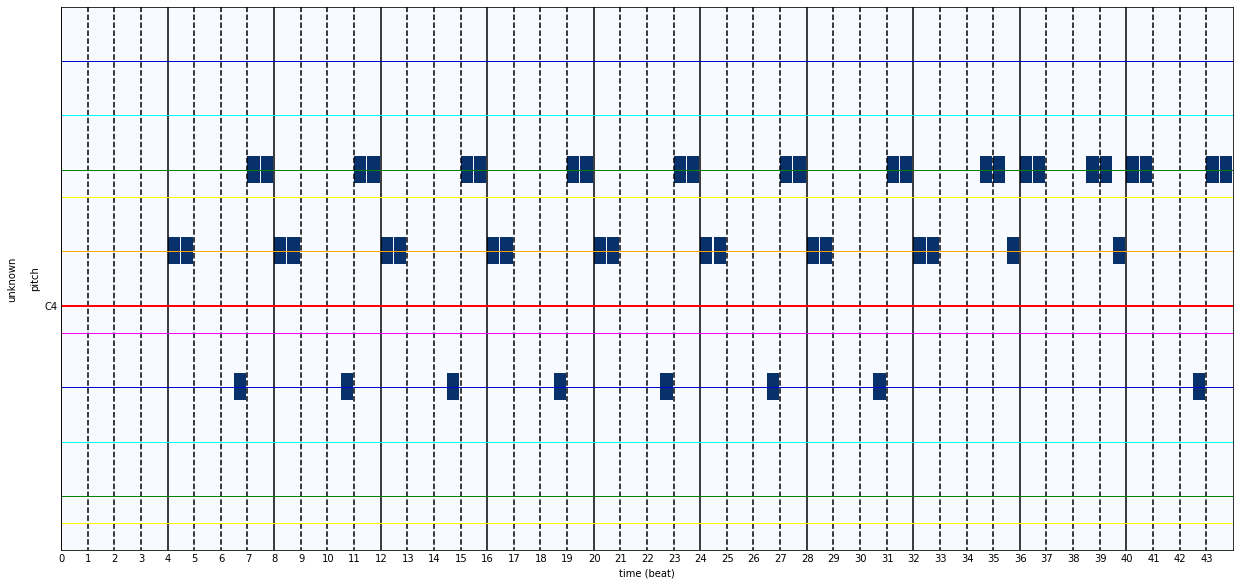

In [24]:
ppr = get_sample()
get_prev_bars = GetPrevBars()
melody = ppr.tracks[0]

for p in [remove_empty_bars, get_bars, augument_bars]:
    ppr, melody = p(ppr, melody)

with Timer():
    ppr, prev_bars = get_prev_bars(ppr, melody)
prev_bars.shape

bars_num = int(np.ceil(len(ppr.downbeat) / (ppr.beat_resolution * 4)))
i = 1
grid_plot(Track(pianoroll=np.vstack(prev_bars[i*bars_num:(i+1)*bars_num])), beat_resolution=ppr.beat_resolution)

In [25]:
class GetPrevTrack(Processor):
    def __init__(self, beats_in_bar=4):
        self.beats_in_bar = beats_in_bar
    
    def __call__(self, ppr, track):
        bars = track.pianoroll if isinstance(track, Track) else track
        steps, pitch_num = bars.shape
        bar_res = ppr.beat_resolution * self.beats_in_bar
        song_len = len(ppr.downbeat)
        augumented_num = steps // song_len
        
        empty_bar = np.zeros([bar_res, pitch_num])
        prev_bars = np.vstack((empty_bar, bars[:-bar_res]))
        
        for a in range(augumented_num):
            prev_bars[song_len*a:song_len*a+bar_res] = empty_bar
        
        return ppr, prev_bars

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
input shape: (1056, 128)
0.001005
output shape: (7392, 128)


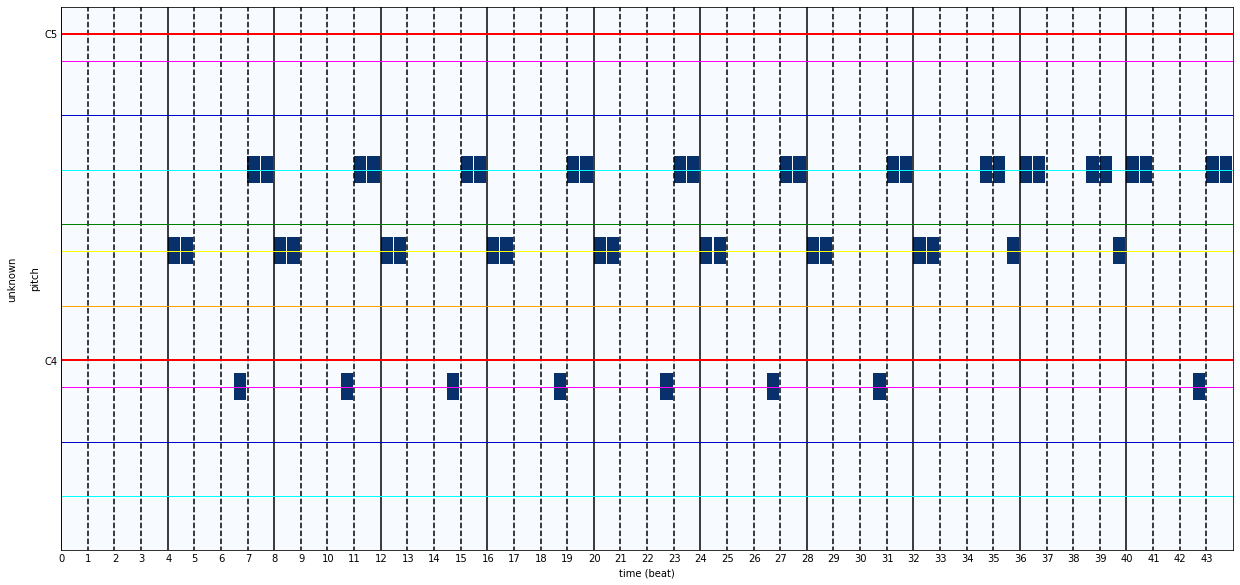

In [26]:
ppr = get_sample()
get_prev_track = GetPrevTrack()
melody = ppr.tracks[0]

for p in [remove_empty_bars, augument_track]:
    ppr, melody = p(ppr, melody)

print("input shape:", ppr.tracks[0].pianoroll.shape)
with Timer():
    ppr, prev_track = get_prev_track(ppr, melody)
print("output shape:", prev_track.shape)

i = 2
song_len = len(ppr.downbeat)
grid_plot(Track(pianoroll=np.vstack(prev_track[i*song_len:(i+1)*song_len])), beat_resolution=ppr.beat_resolution)

### 基本処理計測

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
start global processing
0.000371
0.000007
0.000327
start melody processing
0.000727
0.001174
start prev_melody processing
0.000327
start chord processing
0.000098
0.000087
melody shape: (77, 16, 128)
prev_melody shape: (77, 16, 128)
chord shape: (77, 13)
[0 0 0 0 5 5 0 9 2 7 0 0]
[ 2  2  2  2  7  7  2 11  4  9  2  2]
[ 4  4  4  4  9  9  4  1  6 11  4  4]
[ 5  5  5  5 10 10  5  2  7  0  5  5]
[7 7 7 7 0 0 7 4 9 2 7 7]
[ 9  9  9  9  2  2  9  6 11  4  9  9]
[11 11 11 11  4  4 11  8  1  6 11 11]
[]
[]
[]
[]
[]


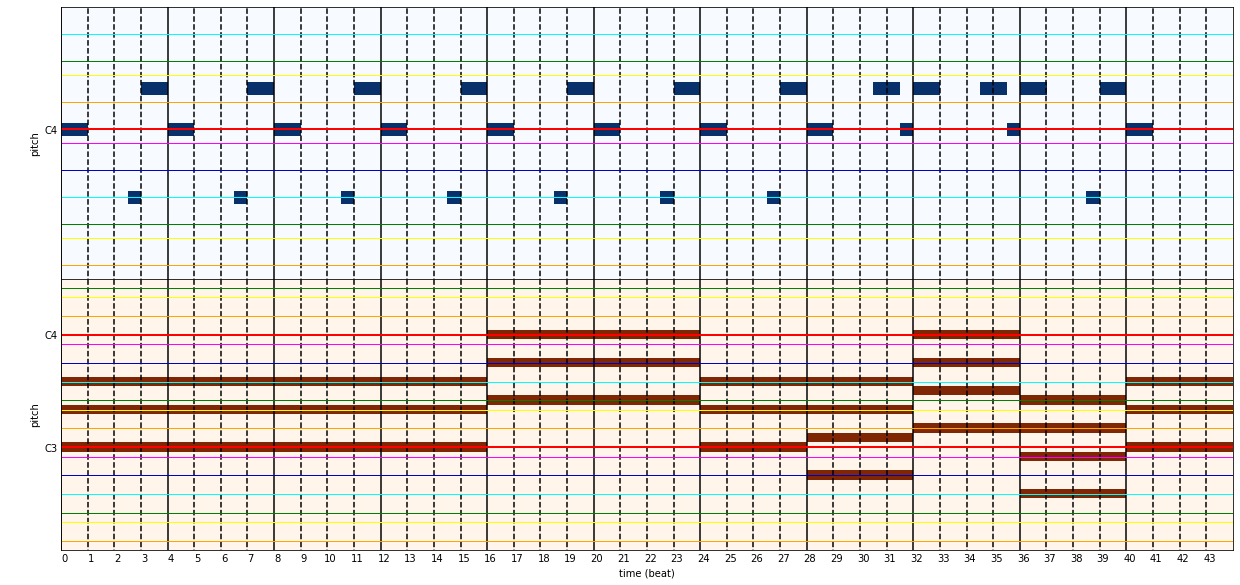

In [27]:
ppr = get_sample()
melody = ppr.tracks[0]

print("start global processing")
for p in [binarize, down_resolution, remove_empty_bars]:
    with Timer():
        ppr, melody = p(ppr, melody)

print("start melody processing")
for p in [get_bars, augument_bars]:
    with Timer():
        ppr, melody = p(ppr, melody)

print("start prev_melody processing")
with Timer():
    ppr, prev_melody = get_prev_bars(ppr, melody)

chord = ppr.tracks[1]
print("start chord processing")
for p in [get_chord_vectors, augument_cv]:
    with Timer():
        ppr, chord = p(ppr, chord)

print("melody shape:", melody.shape)
print("prev_melody shape:", prev_melody.shape)
print("chord shape:", chord.shape)
for i in range(12):
    chords_in_key = augumented_cv[i*cv_len:(i+1)*cv_len, :-1]
    print(np.where(chords_in_key)[1])
grid_plot(ppr)

## original
- トライアドコード以外のコードを含む楽譜を取り除く
- 休符をなくす
    - 休符が後ろについている場合は音符の長さをその分伸ばす
    - 小節の頭が休符の場合は2番目の音符を前に伸ばす
- メロディをC4～C5(C6?)までの2オクターブの中にシフト(でも128音使う．これによりモード崩壊しているかを判定できるらしい)

### トライアドコード以外のコードを含む小節を取り除く
global chord processingとしてmelody processingの前に入れる  
同じ小節に2つ以上のコードがある場合も取り除かれる  
1拍に高々1つのコードしか鳴っていないと仮定し，高速化  
さらに，コードトラックは36~72の3オクターブしか(基本)使っていないので範囲を制限して高速化

In [28]:
class RemoveNonTriadBars(Processor):
    def __init__(self, key=0, beats_in_bar=4, thresh=0, detect_per_beat=True, detect_pitch_range=[36,72]):
        self.key = key
        self.beats_in_bar = beats_in_bar
        self.thresh = thresh
        self.detect_per_beat = detect_per_beat
        self.detect_pitch_lowest, self.detect_pitch_highest = detect_pitch_range
        
        major_scale = [0, 2, 4, 5, 7, 9, 11]
        major_scale = [(pitch + key) % 12 for pitch in major_scale]
        self.major_scale = set(major_scale)
    
    def has_single_diatonic(self, nproll):
        # 小節内で使われている音程を取得
        chroma_list = np.where(nproll > self.thresh)[1] # Bottle Neck
        chroma_set = set(chroma_list)
        
        # トライアドコードは1小節の中にちょうど3つの音程を持つ
        if len(chroma_set) != 3:
            return False
        
        # トライアドコードはすべての音程がkeyのメジャースケールに含まれる
        for pitch in chroma_set:
            if not pitch % 12 in self.major_scale:
                return False

        # トライアドコードのルートと第3和音の距離は3か4でなければならない
        p1, p3 = chroma_list[0], chroma_list[1]
        dist = p3 - p1
        if dist != 3 and dist != 4:
            return False
        
        return True
    
    def __call__(self, ppr, chord_track):
        song_len = len(ppr.downbeat)
        if song_len == 0:
            return ppr, chord_track

        res = ppr.beat_resolution
        detect_res = res if self.detect_per_beat else 1
        bottom, top = self.detect_pitch_lowest, self.detect_pitch_highest
        bar_res = self.beats_in_bar * res
        bars = int(np.ceil(song_len / bar_res))
        
        non_triad_steps = [] 
        for b in range(bars):
            left, right = b*bar_res, min((b+1)*bar_res, song_len)
            detect_area = chord_track.pianoroll[left:right:detect_res, bottom:top]
            if not self.has_single_diatonic(detect_area):
                non_triad_steps += list(range(left, right))
        
        ppr.downbeat = np.delete(ppr.downbeat, non_triad_steps)

        track_is_in_ppr = False
        for ppr_track in ppr.tracks:
            if ppr_track is chord_track: track_is_in_ppr = True
            ppr_track.pianoroll = np.delete(ppr_track.pianoroll, non_triad_steps, axis=0)

        if not track_is_in_ppr:
            chord_track.pianoroll = np.delete(chord_track.pianoroll, non_triad_steps, axis=0)

        return ppr, chord_track

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
start global melody processing
0.000437
0.000010
0.000494
start global chord processing
0.000939


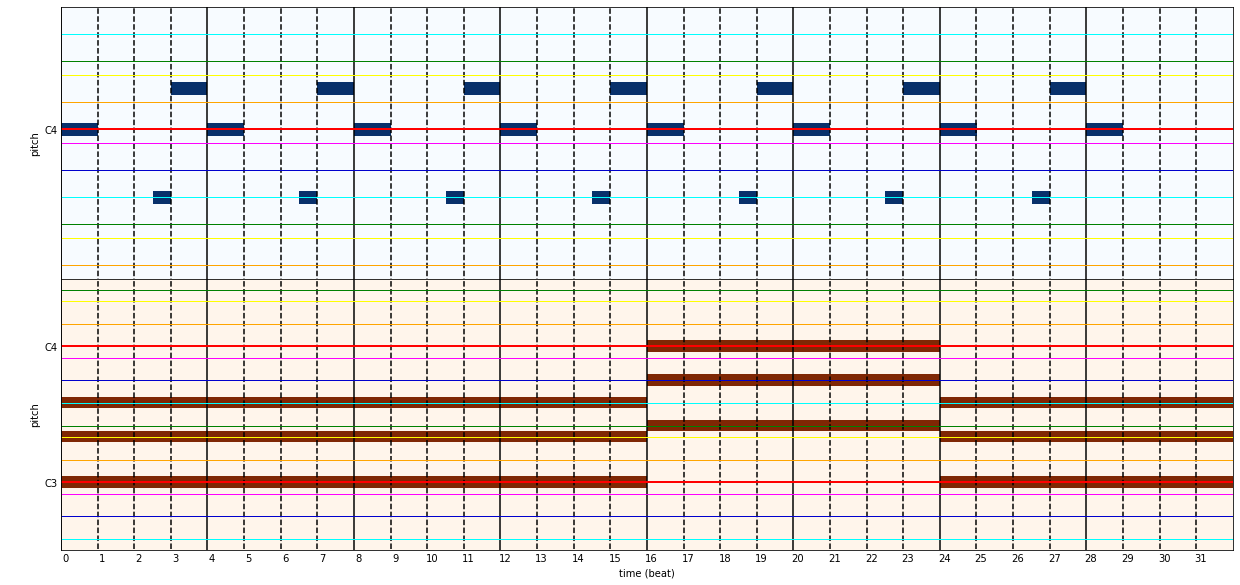

In [29]:
ppr = get_sample(0)
remove_non_triads = RemoveNonTriadBars()
melody = ppr.tracks[0]
chord_track = ppr.tracks[1]

print("start global melody processing")
for p in [binarize, down_resolution, remove_empty_bars]:
    with Timer():
        ppr, melody = p(ppr, melody)

print("start global chord processing")
with Timer():
    ppr, chord_track = remove_non_triads(ppr, chord_track)

grid_plot(ppr)

ここまで厳しくする必要ある？

### 全ての小節をトライアドコードにする
ルートだけ見てキーに合わせる

In [30]:
class ForceTriadBars(Processor):
    def __init__(self, key=0, beats_in_bar=4, thresh=0, detect_per_beat=True, detect_pitch_range=[36,72]):
        self.key = key
        self.beats_in_bar = beats_in_bar
        self.thresh = thresh
        self.detect_per_beat = detect_per_beat
        self.detect_pitch_lowest, self.detect_pitch_highest = detect_pitch_range
        
        major_scale = [0, 2, 4, 5, 7, 9, 11]
        major_scale = [(pitch + key) % 12 for pitch in major_scale]
        self.major_scale = set(major_scale)
    
    def has_single_diatonic(self, nproll):
        # 小節内で使われている音程を取得
        chroma_list = np.where(nproll > self.thresh)[1] # Bottle Neck
        chroma_set = set(chroma_list)
        
        # トライアドコードは1小節の中にちょうど3つの音程を持つ
        if len(chroma_set) != 3:
            return False
        
        # トライアドコードはすべての音程がkeyのメジャースケールに含まれる
        for pitch in chroma_set:
            if not pitch % 12 in self.major_scale:
                return False

        # トライアドコードのルートと第3和音の距離は3か4でなければならない
        p1, p3 = chroma_list[0], chroma_list[1]
        dist = p3 - p1
        if dist != 3 and dist != 4:
            return False
        
        return True
    
    def __call__(self, ppr, chord_track):
        song_len = len(ppr.downbeat)
        if song_len == 0:
            return ppr, chord_track

        res = ppr.beat_resolution
        detect_res = res if self.detect_per_beat else 1
        bottom, top = self.detect_pitch_lowest, self.detect_pitch_highest
        bar_res = self.beats_in_bar * res
        bars = int(np.ceil(song_len / bar_res))
        
        non_triad_steps = [] 
        for b in range(bars):
            left, right = b*bar_res, min((b+1)*bar_res, song_len)
            detect_area = chord_track.pianoroll[left:right:detect_res, bottom:top]
            if not self.has_single_diatonic(detect_area):
                non_triad_steps += list(range(left, right))
        
        ppr.downbeat = np.delete(ppr.downbeat, non_triad_steps)

        track_is_in_ppr = False
        for ppr_track in ppr.tracks:
            if ppr_track is chord_track: track_is_in_ppr = True
            ppr_track.pianoroll = np.delete(ppr_track.pianoroll, non_triad_steps, axis=0)

        if not track_is_in_ppr:
            chord_track.pianoroll = np.delete(chord_track.pianoroll, non_triad_steps, axis=0)

        return ppr, chord_track

### トライアドコード以外のコードを含む「楽譜」を取り除く
取り除くのを「小節」単位にしたら論文の10倍くらいデータができてしまった．  
解釈が異なる点と言えばここかと思うので，めちゃくちゃ厳しくしてみる  
→14万小節くらいになったけど，よく調べたら曲数が1022->9380になっているので，小節数も10倍くらいになるのは驚くべきことではなかった

In [31]:
class RemoveNonTriadSong(Processor):
    def __init__(self, key=0, beats_in_bar=4, thresh=0, detect_per_beat=True, detect_pitch_range=[36,72]):
        self.key = key
        self.beats_in_bar = beats_in_bar
        self.thresh = thresh
        self.detect_per_beat = detect_per_beat
        self.detect_pitch_lowest, self.detect_pitch_highest = detect_pitch_range
        
        major_scale = [0, 2, 4, 5, 7, 9, 11]
        major_scale = [(pitch + key) % 12 for pitch in major_scale]
        self.major_scale = set(major_scale)
    
    def has_single_diatonic(self, nproll):
        # 小節内で使われている音程を取得
        chroma_list = np.where(nproll > self.thresh)[1] # Bottle Neck
        chroma_set = set(chroma_list)
        
        # トライアドコードは1小節の中にちょうど3つの音程を持つ
        if len(chroma_set) != 3:
            return False
        
        # トライアドコードはすべての音程がkeyのメジャースケールに含まれる
        for pitch in chroma_set:
            if not pitch % 12 in self.major_scale:
                return False

        # トライアドコードのルートと第3和音の距離は3か4でなければならない
        p1, p3 = chroma_list[0], chroma_list[1]
        dist = p3 - p1
        if dist != 3 and dist != 4:
            return False
        
        return True
    
    def __call__(self, ppr, chord_track):
        song_len = len(ppr.downbeat)
        if song_len == 0:
            return ppr, chord_track

        res = ppr.beat_resolution
        detect_res = res if self.detect_per_beat else 1
        bottom, top = self.detect_pitch_lowest, self.detect_pitch_highest
        bar_res = self.beats_in_bar * res
        bars = int(np.ceil(song_len / bar_res))
        
        for b in range(bars):
            left, right = b*bar_res, min((b+1)*bar_res, song_len)
            detect_area = chord_track.pianoroll[left:right:detect_res, bottom:top]
            if not self.has_single_diatonic(detect_area):
                # 1瞬でもダイアトニックから外れるなら除外
                non_triad_steps = list(range(song_len))

                ppr.downbeat = np.delete(ppr.downbeat, non_triad_steps)

                track_is_in_ppr = False
                for ppr_track in ppr.tracks:
                    if ppr_track is chord_track: track_is_in_ppr = True
                    ppr_track.pianoroll = np.delete(ppr_track.pianoroll, non_triad_steps, axis=0)

                if not track_is_in_ppr:
                    chord_track.pianoroll = np.delete(chord_track.pianoroll, non_triad_steps, axis=0)
                
                break

        return ppr, chord_track

### メロディを2オクターブの中にシフト
melody processing
- active pitch rangeを求め，その中で作業を行う
- 指定されたbottomとtopの外側の範囲を求め，その中の音符を内側のオクターブへシフトする
    - top - bottom >= 12である必要がある
- 音符が被った場合は，より指定のレンジに近い音に上書きされる

ここに来てようやくわかったけど，pretty_midiのpitch=0はC-1でpypianorollのpitch=0はC-2だった

In [32]:
class ShiftInRange(Processor):
    def __init__(self, bottom, top):
        if bottom < 0 or top > 127:
            raise ValueError("Pitch range must be in [0, 127].")
        if top - bottom < 12:
            raise ValueError("Pitch range must be larger than 12 pitches.")
        self.bottom, self.top = bottom, top
    
    def __call__(self, ppr, track):
        nproll = track.pianoroll if isinstance(track, Track) else track
        bottom, top = self.bottom, self.top
                
        lower_step, lower_pitches = np.where(nproll[:, :bottom])
        new_lower_pitches = lower_pitches - (lower_pitches - bottom) // 12 * 12
        nproll[lower_step, new_lower_pitches] = nproll[lower_step, lower_pitches]
        nproll[lower_step, lower_pitches] = 0
        
        higher_step, higher_pitches_from_top = np.where(nproll[:, top+1:])
        higher_pitches = higher_pitches_from_top + (top + 1)
        new_higher_pitches = higher_pitches - (higher_pitches_from_top + 13) // 12 * 12
        nproll[higher_step, new_higher_pitches] = nproll[higher_step, higher_pitches]
        nproll[higher_step, higher_pitches] = 0
        
        return ppr, track

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
start global melody processing
0.000157


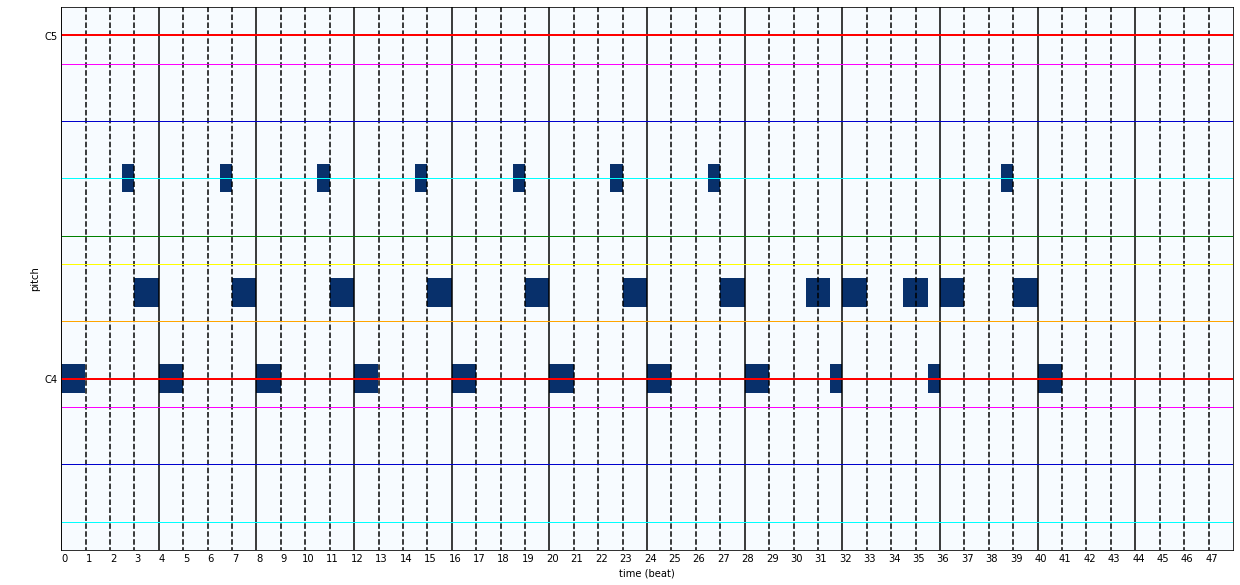

In [33]:
ppr = get_sample()
# bottom, top = 36, 99 # C3 ~ D#7
# bottom, top = 65, 80 # lower to higher
bottom, top = 56, 69 # higer to lower
shift_in_range = ShiftInRange(bottom, top)
melody = ppr.tracks[0]

print("start global melody processing")
for p in [binarize, down_resolution]:
    ppr, melody = p(ppr, melody)

with Timer():
    ppr, melody = shift_in_range(ppr, melody)

grid_plot(melody, beat_resolution=ppr.beat_resolution)

シフトするのは良いけどC4～だと厳しいからC3～にしない？そうしたら8割以上はそのままの音程になる

### 休符をなくす
melody processing
- active pitch rangeを求め，その中で作業を行う→効果なかったので普通にやる
- 小節ごとに以下の処理を行う
    - ステップごとに以下の処理を行う
        - そのステップに音符があるとき
            - もしこのステップまでが休符であったなら以下のように音符で埋める
                - すでに何かしらの音符を見つけているならそれで埋める
                - まだ見つかっていないならこのステップで見つかった音符で埋める
                - 休符のフラグを降ろす
            - 最後に音符が見つかったステップのステップ数と音符を保持
        - そのステップに音符がないとき
            - 休符が始まったというフラグを立てる
    - もしまだ休符で，何かしらの音符が見つかっているなら，その音符で残りの空白を埋める

In [34]:
class RemoveRests(Processor):
    def __init__(self, beats_in_bar=4):
        self.beats_in_bar = beats_in_bar
    
    def __call__(self, ppr, track):
        nproll = track.pianoroll if isinstance(track, Track) else track
        song_len = len(ppr.downbeat)
        bar_res = ppr.beat_resolution * self.beats_in_bar
        bars = int(np.ceil(song_len / bar_res))
        
        for bar in range(bars):
            left, right = bar * bar_res, min((bar+1) * bar_res, song_len)
            last_step, last_pitch, is_in_rest = left, None, False
            
            for step in range(left, right):
                if len(np.where(nproll[step])[0]) > 0:
                    if is_in_rest:
                        if last_pitch is None: 
                            nproll[last_step:step] = nproll[step]
                        else:
                            nproll[last_step+1:step] = last_pitch
                        is_in_rest = False
                    last_step, last_pitch = step, nproll[step]
                else:
                    is_in_rest = True
            
            if is_in_rest and last_pitch is not None:
                nproll[last_step+1:step+1] = last_pitch
        
        return ppr, track

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
start global melody processing
0.000481


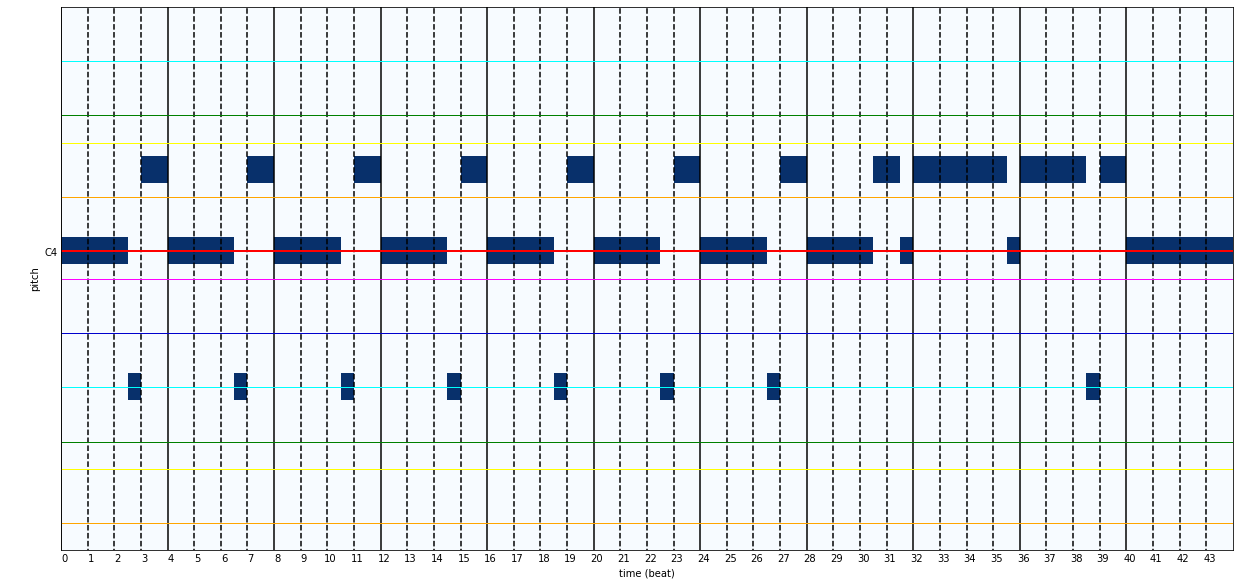

In [35]:
ppr = get_sample()
remove_rests = RemoveRests()
melody = ppr.tracks[0]

print("start global melody processing")
for p in [binarize, down_resolution, remove_empty_bars]:
    ppr, melody = p(ppr, melody)

with Timer():
    ppr, melody = remove_rests(ppr, melody)

grid_plot(melody, beat_resolution=ppr.beat_resolution)

これやる意味ある？

### original処理計測

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid


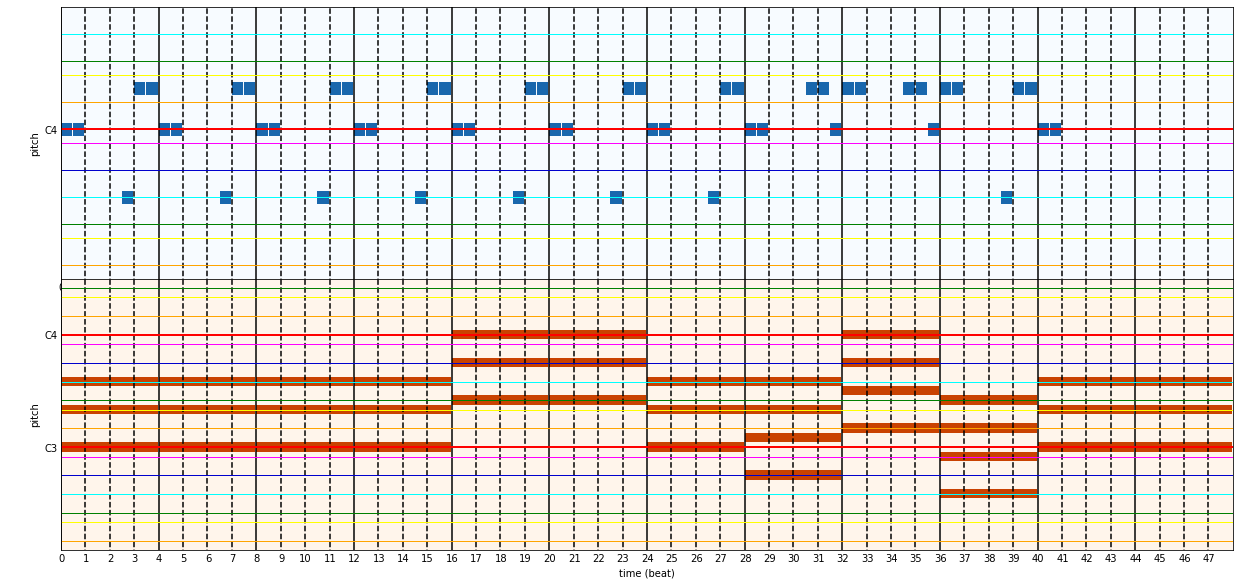

In [36]:
index = 0
ppr = get_sample(index)
grid_plot(ppr)

sample 0 picked from q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid
start global melody processing
0.000298
0.000008
0.000324
start global chord processing
0.000301
start melody processing
0.000364
0.000302
0.000544
0.001176
start prev_melody processing
0.000417
start chord processing
0.000070
0.000075
melody shape: (56, 16, 128)
prev_melody shape: (56, 16, 128)
chord shape: (56, 13)
[0 0 0 0]
[5 5 0 0]
[2 2 2 2]
[7 7 2 2]
[4 4 4 4]
[9 9 4 4]
[5 5 5 5]
[10 10  5  5]
[7 7 7 7]
[0 0 7 7]
[9 9 9 9]
[2 2 9 9]


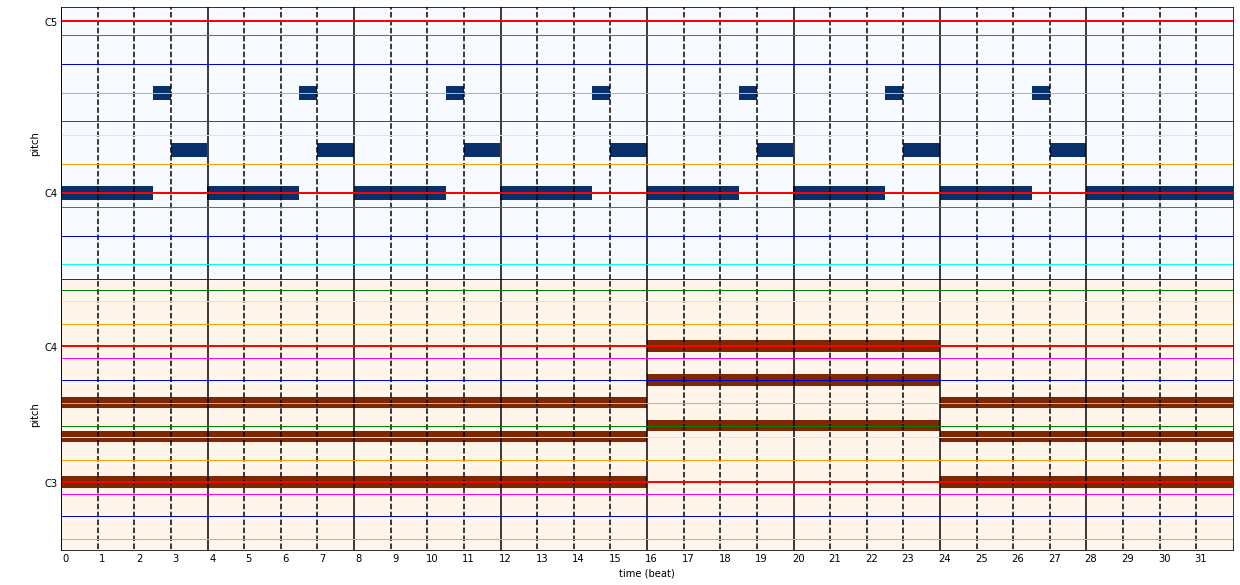

In [37]:
ppr = get_sample(index)
melody = ppr.tracks[0]
chord = ppr.tracks[1]

print("start global melody processing")
for p in [binarize, down_resolution, remove_empty_bars]:
    with Timer():
        ppr, melody = p(ppr, melody)

print("start global chord processing")
for p in [remove_non_triads]:
    with Timer():
        ppr, chord = p(ppr, chord)

print("start melody processing")
for p in [shift_in_range, remove_rests, get_bars, augument_bars]:
    with Timer():
        ppr, melody = p(ppr, melody)

print("start prev_melody processing")
with Timer():
    ppr, prev_melody = get_prev_bars(ppr, melody)

print("start chord processing")
for p in [get_chord_vectors, augument_cv]:
    with Timer():
        ppr, chord = p(ppr, chord)

print("melody shape:", melody.shape)
print("prev_melody shape:", prev_melody.shape)
print("chord shape:", chord.shape)
if len(chord) > 0:
    cv_len = int(len(chord) / 12)
    for i in range(12):
        chords_in_key = chord[i*cv_len:(i+1)*cv_len, :-1]
        print(np.where(chords_in_key)[1])
grid_plot(ppr)

## original全体処理

In [38]:
def process(
        midi_path,
        global_melody_processor, global_chord_processor,
        melody_processor, prev_melody_processor, chord_processor,
        break_by_error=False
    ):
    try:
        ppr = Multitrack(midi_path)
        melody, chord = ppr.tracks
        ppr, melody = PypianorollProcessor(global_melody_processor)(ppr, melody)
        ppr, chord = PypianorollProcessor(global_chord_processor)(ppr, chord)
        ppr, melody = PypianorollProcessor(melody_processor)(ppr, melody)
        ppr, prev_melody = PypianorollProcessor(prev_melody_processor)(ppr, melody)
        ppr, chord = PypianorollProcessor(chord_processor)(ppr, chord)
    except Exception as err:
        if break_by_error:
            raise err
        return (midi_path, None, None, None)
    
    return (midi_path, melody, prev_melody, chord)

In [39]:
beat_resolution =         4
bottom, top =             60, 83
major, minor =            0, 1
global_melody_processor = [Binarize(), DownBeatResolution(beat_resolution), RemoveEmptyBars()]
global_chord_processor =  [RemoveNonTriadSong()]
# global_chord_processor = [RemoveNonTriadBars()] # Full
melody_processor =        [ShiftInRange(bottom=bottom, top=top), RemoveRests(), GetBars(), AugumentBars()]
prev_melody_processor =   [GetPrevBars()]
chord_processor =         [GetChordVectors(major=major, minor=minor), AugumentChordVectors()]

def process_original(mpath):
    return process(mpath, 
             global_melody_processor = global_melody_processor,
             global_chord_processor = global_chord_processor,
             melody_processor = melody_processor,
             prev_melody_processor = prev_melody_processor,
             chord_processor = chord_processor)

../datasets/theorytab/pianoroll/q/queen/under-pressure/intro_nokey.mid
0.421194
melody shape: (96, 16, 128)
prev_melody shape: (96, 16, 128)
chord shape: (96, 13)
[0 0 7 7 5 5 7 7]
[1 1 8 8 6 6 8 8]
[2 2 9 9 7 7 9 9]
[ 3  3 10 10  8  8 10 10]
[ 4  4 11 11  9  9 11 11]
[ 5  5  0  0 10 10  0  0]
[ 6  6  1  1 11 11  1  1]
[7 7 2 2 0 0 2 2]
[8 8 3 3 1 1 3 3]
[9 9 4 4 2 2 4 4]
[10 10  5  5  3  3  5  5]
[11 11  6  6  4  4  6  6]


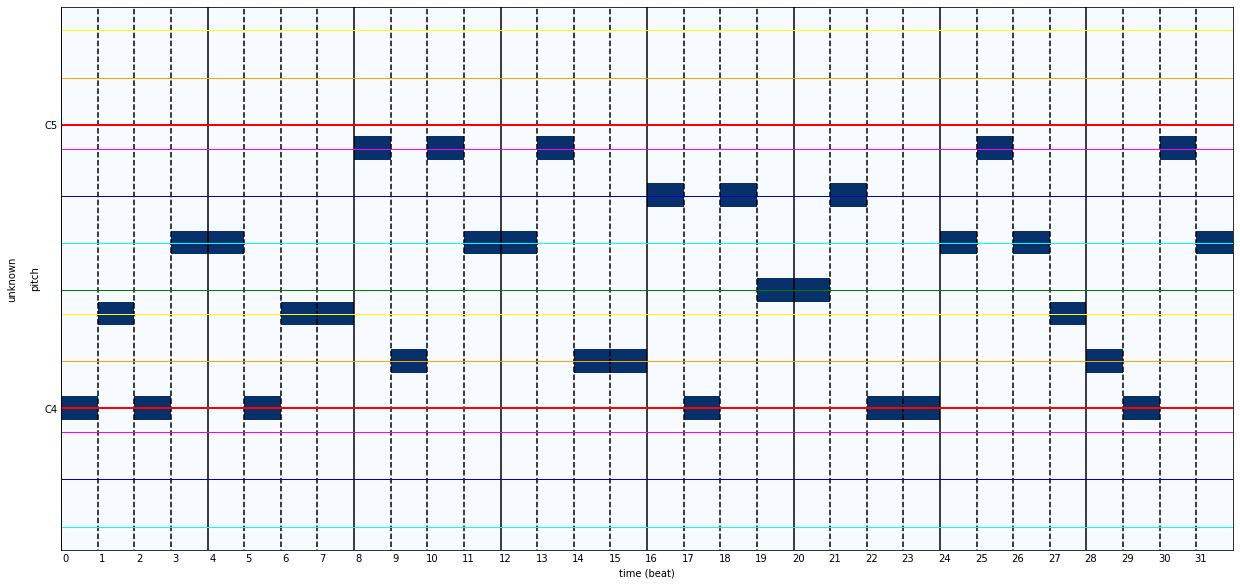

In [40]:
index = 9
midi_path = os.path.join(input_dir, df['path'][index])
print(midi_path)

with Timer():
    _, melody, prev_melody, chord = process_original(midi_path)

print("melody shape:", melody.shape)
print("prev_melody shape:", prev_melody.shape)
print("chord shape:", chord.shape)

if len(chord) > 0:
    cv_len = int(len(chord) / 12)
    for i in range(12):
        chords_in_key = chord[i*cv_len:(i+1)*cv_len, :-1]
        print(np.where(chords_in_key)[1])
grid_plot(Track(np.vstack(melody)[:16*(melody.shape[0]//12)]), beat_resolution=beat_resolution)

## マルチプロセッシングによる全体処理
幾重にも辛酸を舐め、七難八苦を越え、艱難辛苦の果て、満願成就に至る。 

In [41]:
df_mp = pd.read_csv(input_csv)
df_mp = df_mp[df_mp["nokey"] & (df_mp["time_signature"] == "4/4")]
df_mp = df_mp[df_mp["has_melody_track"] & df_mp["has_chord_track"]]
paths = [f"{input_dir}/{path}" for path in df_mp["path"]]
file_num = len(paths)
print("# of midi files to process:", file_num)

# of midi files to process: 16386


In [42]:
output_file_path_original = os.path.join(output_dir, "midinet_original.pkl")

In [43]:
pool = Pool()
melody_list, prev_list, chord_list, error_list, empty_list = [], [], [], [], []

# paths = paths[:100]
with Timer():
    for path, m, p, c in pool.map(process_original, paths):
        if m is None or p is None or c is None:
            error_list.append(path)
        elif len(m) == 0 or len(p) == 0 or len(c) == 0:
            empty_list.append(path)
        else:
            melody_list.append(m)
            prev_list.append(p)
            chord_list.append(c)

with Timer():
    melody_stacked, prev_stacked, chord_stacked = [np.vstack(lst) for lst in [melody_list, prev_list, chord_list]]
    midinet_original = zip(melody_stacked, prev_stacked, chord_stacked) # zipなのでGeneratorなので消えるので注意

print("Preprocessing Finished! ")
print(f"{len(melody_stacked)} bars created")
print(f"{len(empty_list)} songs resulted in empty")
print(f"{len(error_list)} error caused")
print("error file paths")
print(error_list)

11.296296
0.760430
Preprocessing Finished! 
143028 bars created
15195 songs resulted in empty
0 error caused
error file paths
[]


### pickleによる保存と読込
次元が異なるもののトリプレットのリストを保存したかったのでnpzではなくpickleを採用  
4GB以上のファイルでは保存時にエラーが起きる  
`protocol=pickle.HIGHEST_PROTOCOL`というオプションをつけて保存することでエラーを回避できる  
Macの場合はOSErrorが起きるので[ここ](https://qiita.com/NomuraS/items/da3fd3a1ecd76175e5f8)のMac用コードを使おう

In [44]:
with Timer():
    pickle.dump(midinet_original, open(output_file_path_original, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

3.939854


full: 18GBのスッカスカのデータができたよ！やったね！  
original: 4.4GBのリーズナブルなデータができたよ！

In [45]:
with Timer():
    midinet_original = pickle.load(open(output_file_path_original,'rb'))

3.769428


In [46]:
melody, prev, chord = [], [], []
for m, p, c in midinet_original:
    melody.append(m)
    prev.append(p)
    chord.append(c)

print(f"{len(melody)} bars")
print(f"{len(melody) // 12} original bars")

143028 bars
11919 original bars


[0 0 7 7 5 5 7 7]


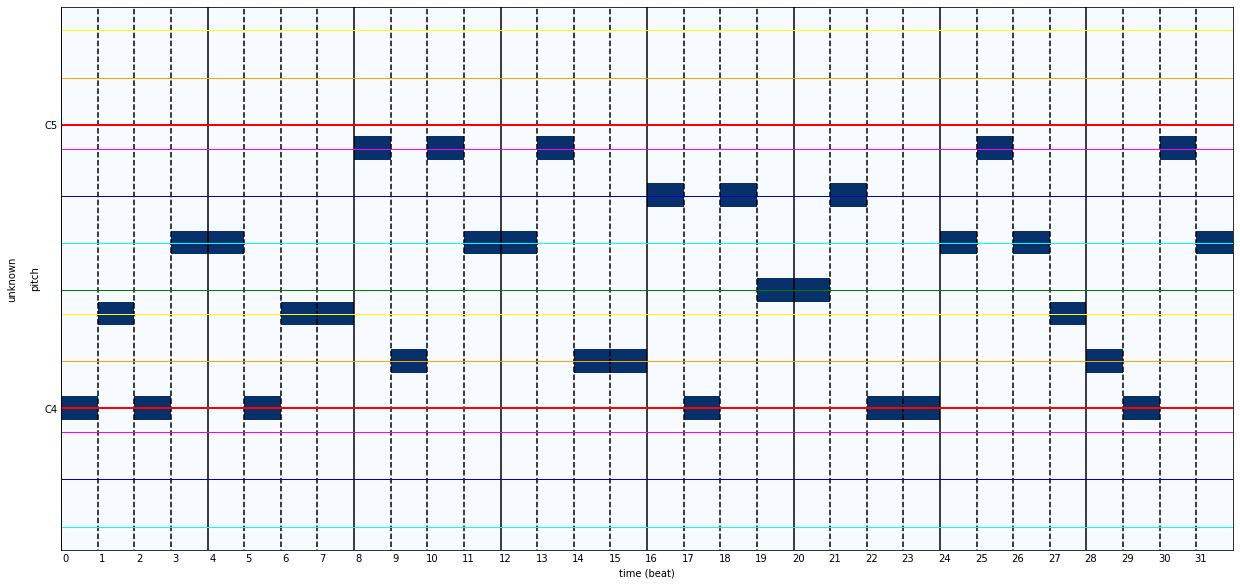

In [47]:
left = 0
right = left+8
print(np.where(np.vstack(chord[left:right])[:, :-1])[1])
grid_plot(Track(pianoroll=np.vstack(melody[left:right])), beat_resolution=4)

## natural
- 休符，空の小節は消さない
    - 空の小節が消えることでprevがズレる現象が発生するが，対応がめんどいため
- トライアドでないコードは一番下の音をルートとし，第3和音との距離でメジャーマイナーを決める
    - 本当は展開形にも対応したいが，4，5和音などに対応しようとするとめんどいため．あんまし影響ないっしょ
- ピッチシフトのレンジを下に1オクターブ拡張
- データの水増し
    1. 十分にデータがあるので水増ししない
    2. メジャースケール上で水増しする

In [48]:
global_melody_processor_natural = [Binarize(), DownBeatResolution(4)]
melody_processor_natural =        [ShiftInRange(bottom=48, top=83), GetBars()]
prev_melody_processor_natural =   [GetPrevBars()]
chord_processor_natural =         [GetChordVectors(major=0, minor=1)]

def process_natural(mpath):
    return process(mpath, 
             global_melody_processor = global_melody_processor_natural,
             global_chord_processor = [],
             melody_processor = melody_processor_natural,
             prev_melody_processor = prev_melody_processor_natural,
             chord_processor = chord_processor_natural)

In [41]:
major_scale = [0, 2, 4, 5, 7, 9, 11]
global_melody_processor_natural2 = [Binarize(), DownBeatResolution(4)]
melody_processor_natural2 =        [ShiftInRange(bottom=48, top=83), GetBars(), AugumentBars(shifts=major_scale)]
prev_melody_processor_natural2 =   [GetPrevBars()]
chord_processor_natural2 =         [GetChordVectors(major=0, minor=1), AugumentChordVectors(shifts=major_scale)]

def process_natural2(mpath):
    return process(mpath, 
             global_melody_processor = global_melody_processor_natural2,
             global_chord_processor = [],
             melody_processor = melody_processor_natural2,
             prev_melody_processor = prev_melody_processor_natural2,
             chord_processor = chord_processor_natural2)

../datasets/theorytab/pianoroll/q/queen/under-pressure/intro_nokey.mid
0.010706
melody shape: (56, 16, 128)
prev_melody shape: (56, 16, 128)
chord shape: (56, 13)
[0 0 0 0 5 5 0 9]
[2 7 0 0 2 2 2 2]
[ 7  7  2 11  4  9  2  2]
[4 4 4 4 9 9 4 1]
[ 6 11  4  4  5  5  5  5]
[10 10  5  2  7  0  5  5]
[7 7 7 7 0 0 7 4]


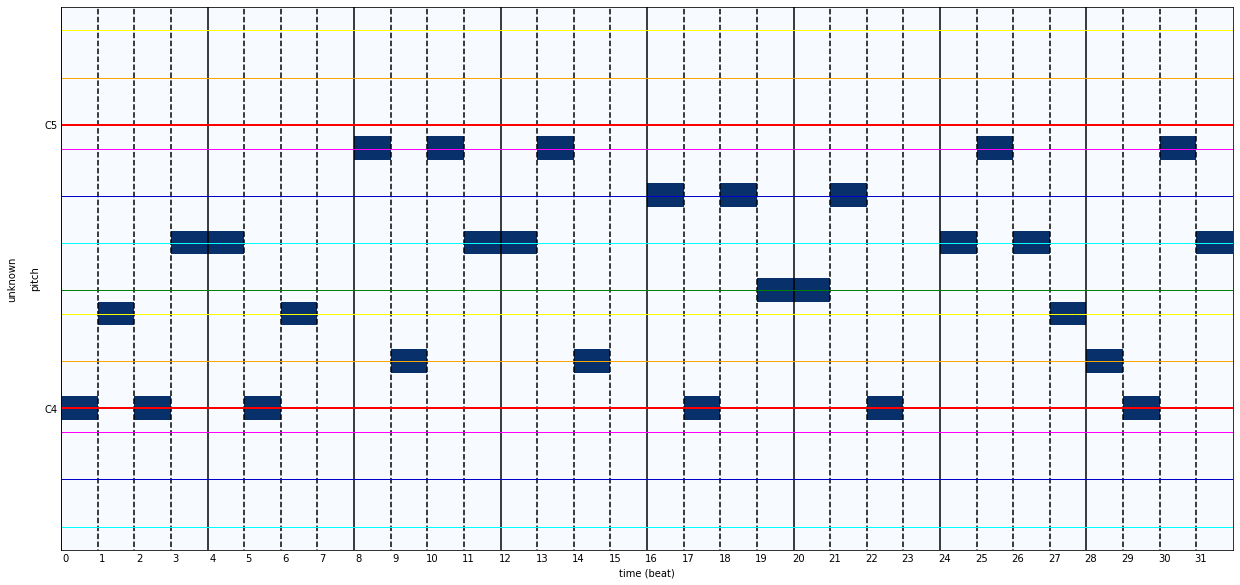

In [42]:
index = 9
midi_path = os.path.join(input_dir, df['path'][index])
print(midi_path)

with Timer():
    _, melody, prev_melody, chord = process_natural2(midi_path)

print("melody shape:", melody.shape)
print("prev_melody shape:", prev_melody.shape)
print("chord shape:", chord.shape)

for i in range(len(major_scale)):
    chords_in_key = augumented_cv[i*cv_len:(i+1)*cv_len, :-1]
    print(np.where(chords_in_key)[1])

i = 0
grid_plot(Track(np.vstack(melody[i*8:(i+1)*8])), beat_resolution = 4)

In [43]:
df_mp = pd.read_csv(input_csv)
df_mp = df_mp[df_mp["nokey"] & (df_mp["time_signature"] == "4/4")]
df_mp = df_mp[df_mp["has_melody_track"] & df_mp["has_chord_track"]]
paths = [f"{input_dir}/{path}" for path in df_mp["path"]]
file_num = len(paths)
print("# of midi files to process:", file_num)

# of midi files to process: 16386


In [4]:
output_file_path_natural = os.path.join(output_dir, "midinet_natural.pkl")

In [45]:
pool = Pool()
melody_list, prev_list, chord_list, error_list, empty_list = [], [], [], [], []

with Timer():
    for path, m, p, c in pool.map(process_natural, paths):
        if m is None or p is None or c is None:
            error_list.append(path)
        elif len(m) == 0 or len(p) == 0 or len(c) == 0:
            empty_list.append(path)
        else:
            melody_list.append(m)
            prev_list.append(p)
            chord_list.append(c)

with Timer():
    melody_stacked, prev_stacked, chord_stacked = [np.vstack(lst) for lst in [melody_list, prev_list, chord_list]]
    midinet_natural = zip(melody_stacked, prev_stacked, chord_stacked) # zipなのでGeneratorなので消えるので注意

print("Preprocessing Finished! ")
print(f"{len(melody_stacked)} bars created")
print(f"{len(empty_list)} songs resulted in empty")
print(f"{len(error_list)} error caused")
print("error file paths")
print(error_list)

92.976824
6.750077
Preprocessing Finished! 
1272075 bars created
0 songs resulted in empty
0 error caused
error file paths
[]


In [46]:
with Timer():
    pickle.dump(midinet_natural, open(output_file_path_natural, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

242.034543


In [5]:
with Timer():
    midinet_natural = pickle.load(open(output_file_path_natural,'rb'))

245.344918


In [6]:
melody, prev, chord = [], [], []
for m, p, c in midinet_natural:
    melody.append(m)
    prev.append(p)
    chord.append(c)
print(f"{len(melody)} bars")
print(f"{len(melody) // 7} original bars")

1272075 bars
181725 original bars


[0 0 0 0 5 5 0 9 2 7 0 0 2 2 2 2]


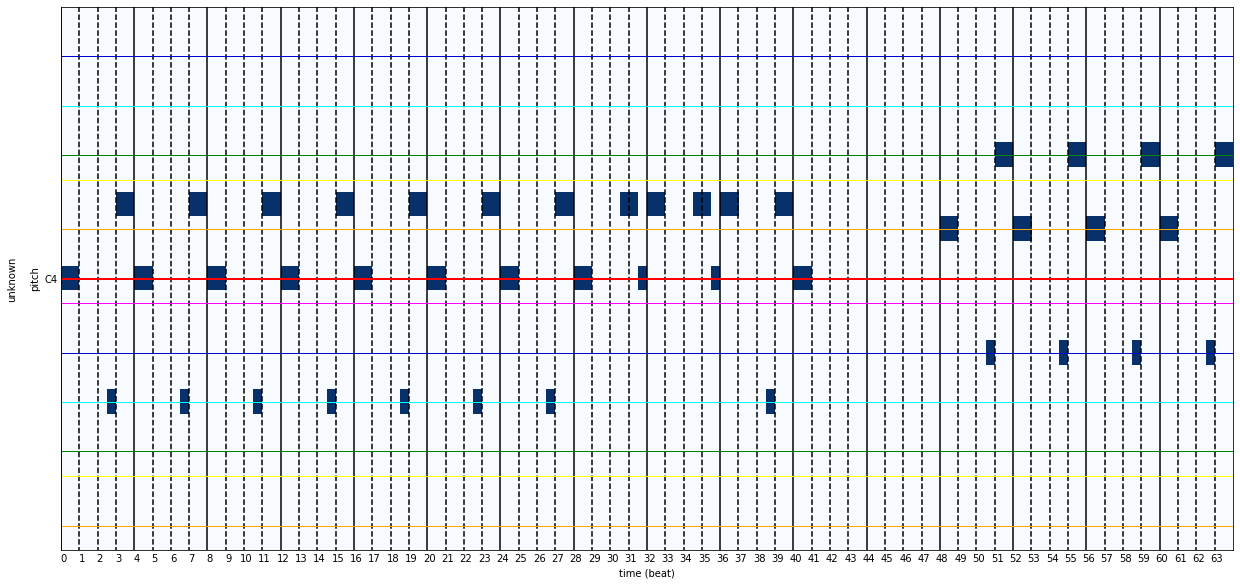

In [7]:
left = 0
right = left+16
print(np.where(np.vstack(chord[left:right])[:, :-1])[1])
grid_plot(Track(pianoroll=np.vstack(melody[left:right])), beat_resolution=4)

## headed
音符の先頭からいくつ伸ばすかを指定する形式にする  
Binarize -> RemoveEmptyBars -> 「EncodeToHeaded」 -> 「DownBeatResolutionHeaded」 -> RemoveNonTriadSong -> ShiftInRange -> GetBars -> AugumentBars?  
もちろん空白は消さない

### EncodeToHeaded
音符の先頭からいくつ伸びているかを数える  
resolution=24の時に音符の右端に空白ができるみたいなのでそれを参考にする

### DecodeFromHeaded
可視化用に作成  
resolutionと音符の終端マージンを指定できるようにする

### DownBeatResolutionHeaded
バイナリではないので，伸びてる数を割る処理を行う